In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [5]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
def to_torch(x: np.ndarray):
    return torch.tensor(x).float().view(-1, 1).to(device)

def to_numpy(x: torch.Tensor):
    return x.detach().cpu().numpy()

def gradient(y, x):
    return torch.autograd.grad(y, x,
                grad_outputs=torch.ones_like(x),
                create_graph = True,
                only_inputs=True)[0]

@torch.no_grad()
def predict(model, x):
    model.eval()
    pred = model(to_torch(x))
    return to_numpy(pred)

def mse_loss(model, x: np.ndarray, y: np.ndarray):
    y_pred = model(to_torch(x))
    y_true = to_torch(y)
    return torch.mean((y_pred - y_true)**2)

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)
        
def get_model(input_dim, output_dim, hidden_dim=100):
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_dim), nn.Tanh(),
        nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
        nn.Linear(hidden_dim, output_dim)
    )
    return model

In [10]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
    
    def init(self):
        self.model.apply(init_normal)
        return self

    def fit(self, t, n_epochs, ic=None, data=None):
        self.model.train()
        losses = {"total": [], "eqn": [], "ic": [], "data": []}
        with tqdm(range(1, n_epochs + 1), ascii=True) as pbar:
            for epoch in pbar:
                self.optimizer.zero_grad()
                loss_total = loss_eqn = self.loss_fn(self.model, t)
                losses["eqn"].append(loss_eqn.item())

                if ic is not None:
                    loss_ic = mse_loss(self.model, ic[0], ic[1])
                    loss_total += loss_ic
                    losses["ic"].append(loss_ic.item())

                if data is not None:
                    loss_data = mse_loss(self.model, data[0], data[1])
                    loss_total += loss_data
                    losses["data"].append(loss_data.item())

                losses["total"].append(loss_total.item())
                loss_total.backward()
                self.optimizer.step()

                if epoch % 100 == 0:
                    desc = ' '.join([f"{name}: {values[-1]:.2e}" 
                                        for name, values in losses.items() if len(values) > 0])
                    pbar.set_description(f"Epoch[{epoch}/{n_epochs}] " + desc)
        return losses

Epoch[10000/10000] total: 1.17e-02 eqn: 1.44e-04 ic: 1.06e-06 data: 1.15e-02: 100%|##########| 10000/10000 [01:18<00:00, 127.19it/s]


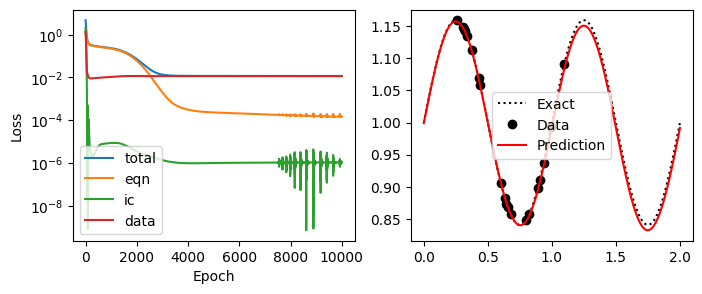

In [11]:
def solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

def loss_fn(model, t):
    t = to_torch(t).requires_grad_(True)
    u = model(t)
    u_t = gradient(u, t)
    eqn = u_t - torch.cos(2 * np.pi * t)
    return torch.mean(eqn**2)

# Hyperparameters
learning_rate = 1e-4
n_epochs = 10000
n_samples = 20

# Model
model = get_model(input_dim=1, output_dim=1, hidden_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data
t_data = np.linspace(0.25, 1, n_samples) + np.random.randn(n_samples) * 0.1
u_data = solution(t_data) +  np.random.randn(n_samples) * 0.1

# Mesh
t = np.linspace(0, 2, 1001)
ones = np.ones_like(t)

# Train
ivp = Trainer(model, optimizer, loss_fn).init()
losses = ivp.fit(t, n_epochs, ic=[0*ones, 1*ones], data=[t_data, u_data])

# t = np.linspace(-1, 3, 1001)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
for name in losses:
    if len(losses[name]) > 0:
        ax1.semilogy(losses[name], label=name)
ax2.plot(t, solution(t), 'k:', label="Exact")
ax2.plot(t_data, solution(t_data), 'ko', label="Data")
ax2.plot(t, predict(model, t), 'r', label="Prediction")
ax1.legend(); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
ax2.legend()
plt.show()